In [3]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sqlite3
import warnings
from scipy.stats import linregress
warnings.filterwarnings('ignore')
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import random
from matplotlib import pyplot as plt

In [4]:
conn = sqlite3.connect("twse_data_revised.db")

In [5]:
df = pd.read_sql_query("SELECT * FROM stock_data", conn)

In [6]:
df.fillna(0, inplace=True)

## First model: 三因子模型 basic capm + SMB + HML 

$$
R_i - R_f = \alpha + \beta_{MKT}(R_M - R_f) + \beta_{SMB} \times SMB + \beta_{HML} \times HML
$$

- R_i：個別股票或投資組合的回報率
- R_f：無風險利率：我們在這裡用美國最新10年期公債利率
- R_M：市場組合的回報率：我們在使用0050的回報
- (R_M - R_f)：市場風險溢酬
- **SMB (Small Minus Big)**：將市場中所有股票依市值排序分組，然後計算各組的平均回報。 我們前3% and 後3%
- **HML (High Minus Low)**：High B/M - Low B/M 我們在這裡需要額外的數據
    - B/M = 每股參考淨值 / 股價

### 爬取額外的數據:每股參考淨值

In [7]:
import selenium
import requests
from bs4 import BeautifulSoup

In [8]:
def tpex_header():
    return {
        "User-Agent": "Mozilla/5.0",
        "Content-Type": "application/x-www-form-urlencoded",
        "Referer": "https://mopsov.twse.com.tw/mops/web/t163sb04"  # Often helps
    }

payload = {
    "encodeURIComponent": "1",  # Commonly required on MOPS to indicate encoding
    "step": "1",
    "firstin": "1",
    "off": "1",
    "co_id": "",                # Usually blank unless you're searching for a specific company code
    "isnew": "false",           # Often required in MOPS forms
    "TYPEK": "sii",            # ‘sii’ = 上市, ‘otc’ = 上櫃, ‘rotc’ = 興櫃, etc.
    "year": "108",             # Year in ROC format (e.g. 108 = 2019). Keep it as a string.
    "season": "01",            # '01' = Q1, '02' = Q2, '03' = Q3, '04' = Q4
}

In [ ]:
url = "https://mopsov.twse.com.tw/mops/web/t163sb05"
response = requests.post(url, headers=tpex_header(), data=payload)


In [ ]:
text = BeautifulSoup(response.text, "html.parser")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103b7fd90>>
Traceback (most recent call last):
  File "/Users/zhuoweiyi/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
text.find_all("tr",class_="tblHead")

[<tr class="tblHead"><th align="center" width="100px">公司<br/>代號</th><th align="center" width="100px">公司名稱</th><th align="center" nowrap="" width="100px">現金及約當現金</th><th align="center" nowrap="" width="100px">存放央行及拆借銀行同業</th><th align="center" nowrap="" width="100px">透過損益按公允價值衡量之金融資產</th><th align="center" nowrap="" width="100px">透過其他綜合損益按公允價值衡量之金融資產</th><th align="center" nowrap="" width="100px">按攤銷後成本衡量之債務工具投資</th><th align="center" nowrap="" width="100px">避險之衍生金融資產淨額</th><th align="center" nowrap="" width="100px">附賣回票券及債券投資淨額</th><th align="center" nowrap="" width="100px">應收款項－淨額</th><th align="center" nowrap="" width="100px">當期所得稅資產</th><th align="center" nowrap="" width="100px">待出售資產－淨額</th><th align="center" nowrap="" width="100px">待分配予業主之資產－淨額</th><th align="center" nowrap="" width="100px">貼現及放款－淨額</th><th align="center" nowrap="" width="100px">採用權益法之投資－淨額</th><th align="center" nowrap="" width="100px">受限制資產－淨額</th><th align="center" nowrap="" width="100px">其他金融資產－淨額</th><th alig

In [ ]:
row = text.find_all("tr", class_=["even","odd"])

In [ ]:
row[0]

<tr class="even"><td align="center" nowrap="" width="100px">2801</td><td align="center" nowrap="" width="100px">彰銀</td><td align="right" nowrap="" width="100px">50,807,365</td><td align="right" nowrap="" width="100px">210,256,545</td><td align="right" nowrap="" width="100px">8,892,021</td><td align="right" nowrap="" width="100px">95,753,735</td><td align="right" nowrap="" width="100px">260,258,988</td><td align="right" nowrap="" width="100px">261,845</td><td align="right" nowrap="" width="100px">--</td><td align="right" nowrap="" width="100px">25,871,665</td><td align="right" nowrap="" width="100px">1,290,979</td><td align="right" nowrap="" width="100px">--</td><td align="right" nowrap="" width="100px">--</td><td align="right" nowrap="" width="100px">1,338,709,421</td><td align="right" nowrap="" width="100px">--</td><td align="right" nowrap="" width="100px">--</td><td align="right" nowrap="" width="100px">50,986,526</td><td align="right" nowrap="" width="100px">21,051,054</td><td align

In [ ]:
extracted_data = []
for r in row:
    tds = r.find_all("td")
    if tds:  # ensure the row has <td> elements
        # Get the first two and last element from this row
        row_data = [tds[0].get_text(strip=True), tds[1].get_text(strip=True), tds[-1].get_text(strip=True)]
        extracted_data.append(row_data)



In [ ]:
# pd.DataFrame(extracted_data, columns=["公司代號", "公司名稱", "每股參考淨值"])

In [ ]:
def fetch_mops_data(year, season):
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd

    def tpex_header():
        return {
            "User-Agent": "Mozilla/5.0",
            "Content-Type": "application/x-www-form-urlencoded",
            "Referer": "https://mopsov.twse.com.tw/mops/web/t163sb04"
        }

    payload = {
        "encodeURIComponent": "1",
        "step": "1",
        "firstin": "1",
        "off": "1",
        "co_id": "",
        "isnew": "false",
        "TYPEK": "sii",
        "year": str(year),
        "season": str(season).zfill(2)
    }

    url = "https://mopsov.twse.com.tw/mops/web/t163sb05"
    response = requests.post(url, headers=tpex_header(), data=payload)
    soup = BeautifulSoup(response.text, "html.parser")

    header_rows = soup.find_all("tr", class_="tblHead")
    capital_stock_indices = []
    column_lengths = []

    for header in header_rows:
        ths = header.find_all("th")
        column_lengths.append(len(ths))
        for idx, th in enumerate(ths):
            if "股本" in th.text:
                capital_stock_indices.append(idx)
                break

    rows = soup.find_all("tr", class_=["even", "odd"])
    extracted_data = []

    for r in rows:
        tds = r.find_all("td")
        if tds and len(tds) in column_lengths:
            index_to_use = column_lengths.index(len(tds))
            capital_stock_index = capital_stock_indices[index_to_use]

            company_id = tds[0].get_text(strip=True)
            company_name = tds[1].get_text(strip=True)
            net_value_per_share = tds[-1].get_text(strip=True)
            capital_stock = tds[capital_stock_index].get_text(strip=True)

            extracted_data.append([company_id, company_name, net_value_per_share, capital_stock])

    df = pd.DataFrame(extracted_data, columns=["公司代號", "公司名稱", "每股參考淨值", "股本"])
    
    df["股本"] = df["股本"].str.replace(",", "").astype(int)

    return df
def add_每股參考淨值_to_daily(daily_df):
    daily_df["交易日期"] = pd.to_datetime(daily_df["交易日期"])
    daily_df["ROC_year"] = daily_df["交易日期"].dt.year - 1911
    daily_df["season"] = daily_df["交易日期"].dt.month.apply(lambda m: 1 if m <= 3 else 2 if m <= 6 else 3 if m <= 9 else 4)
    daily_df["每股參考淨值"] = None
    daily_df["股本"] = None

    for year in tqdm(range(109, 114), desc="ROC Years"):
        for season in tqdm(range(1, 5), desc="Season", leave=False):
            seasonal_df = fetch_mops_data(year, season)
            nav_mapping = dict(zip(seasonal_df["公司代號"], seasonal_df["每股參考淨值"]))
            capital_mapping = dict(zip(seasonal_df["公司代號"], seasonal_df["股本"]))
            mask = (daily_df["ROC_year"] == year) & (daily_df["season"] == season)
            daily_df.loc[mask, "每股參考淨值"] = daily_df.loc[mask, "證券代號"].map(nav_mapping)
            daily_df.loc[mask, "股本"] = daily_df.loc[mask, "證券代號"].map(capital_mapping)

    daily_df["每股參考淨值"] = daily_df["每股參考淨值"].fillna(0)
    daily_df["股本"] = daily_df["股本"].fillna(0).astype(int)
    daily_df.drop(columns=["ROC_year", "season"], inplace=True)
    return daily_df

In [ ]:
model_df = df.copy()

In [ ]:
add_每股參考淨值_to_daily(model_df)

ROC Years: 100%|██████████| 5/5 [04:03<00:00, 48.68s/it]


,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,交易日期,每股參考淨值,股本
0,0050,元大台灣50,4882015,2421,476649683,97.05,98,97.05,97.65,+,0.70,97.65,168.0,97.7,1,0,2020-01-02,0,0
1,0051,元大中型100,15300,14,542158,35.19,35.48,35.19,35.45,+,0.29,35.46,13.0,35.48,2,0,2020-01-02,0,0
2,0052,富邦科技,139747,49,10235681,72.3,73.45,72.3,73.3,+,1.10,73.3,1.0,73.45,3,0,2020-01-02,0,0
3,0053,元大電子,19000,13,808800,42.6,42.71,42.5,42.7,+,0.53,42.72,15.0,42.92,9,0,2020-01-02,0,0
4,0054,元大台商50,11000,4,272030,24.78,24.78,24.7,24.75,+,0.18,24.78,25.0,24.9,1,0,2020-01-02,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425187,9944,新麗,115881,134,2329626,20.05,20.3,19.95,20.3,+,0.15,19.95,1.0,20.3,2,169.17,2024-12-31,33.28,1091071
1425188,9945,潤泰新,4357585,3703,186985362,43.3,43.35,42.65,42.9,-,0.80,42.9,12.0,42.95,11,10.78,2024-12-31,35.75,28442251
1425189,9946,三發地產,156969,161,3551688,22.95,22.95,22.5,22.6,-,0.30,22.5,19.0,22.8,8,25.68,2024-12-31,20.54,3265542
1425190,9955,佳龍,123625,178,3521198,28.7,28.7,28.3,28.5,-,0.20,28.35,1.0,28.5,7,0,2024-12-31,11.20,1045137


In [ ]:
model_df.to_csv("model_df.csv", index=False)

NameError: name 'model_df' is not defined

### 計算- **SMB (Small Minus Big)**：將市場中所有股票依市值排序分組，然後計算各組的平均回報。 我們前3% and 後3%

In [ ]:
import numpy as np
import pandas as pd
model_df = pd.read_csv("model_df.csv")
model_df = model_df[model_df["交易日期"] < "2024-01-01"]

/var/folders/l0/ycf7g2hn2sj3jcdc9w2z3k6c0000gn/T/ipykernel_84522/1397483989.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  model_df = pd.read_csv("model_df.csv")


## 計算RI 

In [ ]:
model_df = model_df.sort_values(by=['證券代號', '交易日期'])
model_df['收盤價'] = pd.to_numeric(model_df['收盤價'], errors='coerce')
model_df['R_i'] = model_df.groupby('證券代號')['收盤價'].pct_change()
model_df['R_i'].isna().mean()

/var/folders/l0/ycf7g2hn2sj3jcdc9w2z3k6c0000gn/T/ipykernel_84522/2631840587.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  model_df['R_i'] = model_df.groupby('證券代號')['收盤價'].pct_change()


0.0018172990025203623

In [ ]:
model_df['市值估算'] = model_df['收盤價'] * model_df['股本'] / 10

returns_df = model_df.pivot(index='交易日期', columns='證券代號', values='R_i')
size_df = model_df.pivot(index='交易日期', columns='證券代號', values='市值估算')

def calc_smb(row_ret, row_size):
    valid = row_ret.notna() & row_size.notna()
    if valid.sum() < 10:
        return np.nan
    sizes = row_size[valid]
    rets = row_ret[valid]
    threshold_small = sizes.quantile(0.03)
    threshold_big = sizes.quantile(0.97)
    small_group = rets[sizes <= threshold_small]
    big_group = rets[sizes >= threshold_big]
    return small_group.mean() - big_group.mean()

smb_series = returns_df.apply(lambda row: calc_smb(row, size_df.loc[row.name]), axis=1)
smb_df = pd.DataFrame({'交易日期': smb_series.index, 'SMB': smb_series.values})

### 計算- **HML (High Minus Low)**：High B/M - Low B/M 
    - B/M = 每股參考淨值 / 股價

In [ ]:
model_df['每股參考淨值'] = pd.to_numeric(model_df['每股參考淨值'], errors='coerce')
model_df['B/M'] = model_df['每股參考淨值'] / model_df['收盤價']

def compute_hml(group):
    median_bm = group['B/M'].median()
    group['B/M分類'] = group['B/M'].apply(lambda x: 'High' if x > median_bm else 'Low')
    return group

df_hml = model_df.groupby('交易日期').apply(compute_hml).reset_index(drop=True) 

hml_daily = df_hml.groupby(['交易日期', 'B/M分類'])['R_i'].mean().unstack()

hml_daily['HML'] = hml_daily['High'] - hml_daily['Low']

hml_daily = hml_daily[['HML']].reset_index()


/var/folders/l0/ycf7g2hn2sj3jcdc9w2z3k6c0000gn/T/ipykernel_84522/1222219588.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_hml = model_df.groupby('交易日期').apply(compute_hml).reset_index(drop=True)


In [ ]:
import pandas as pd
import statsmodels.api as sm

market_code = '0050'
market_df = model_df[model_df['證券代號'] == market_code][['交易日期', 'R_i']].copy()
market_df['R_M'] = market_df['R_i']
market_df['R_f'] = 0.02 / 252
market_df['R_M_minus_R_f'] = market_df['R_M'] - market_df['R_f']

factor_df = market_df[['交易日期', 'R_M', 'R_f', 'R_M_minus_R_f']] \
    .merge(smb_df, on='交易日期', how='inner') \
    .merge(hml_daily, on='交易日期', how='inner')

df_model = model_df.merge(factor_df, on='交易日期', how='inner')
df_model['Excess_Ri'] = df_model['R_i'] - df_model['R_f']
df_model = df_model.dropna(subset=['Excess_Ri', 'R_M_minus_R_f', 'SMB', 'HML'])

## Second model: 四因子模型 basic capm + SMB + HML + MoM

### 計算MOM

In [ ]:
model_df = model_df.sort_values(by=['證券代號', '交易日期'])
model_df['price_lag_2m'] = model_df.groupby('證券代號')['收盤價'].shift(42)   # 約 2 個月 = 42 交易日
model_df['price_lag_12m'] = model_df.groupby('證券代號')['收盤價'].shift(252) # 約 12 個月 = 252 交易日

model_df['MOM'] = model_df['price_lag_2m'] / model_df['price_lag_12m'] - 1

In [ ]:
# 將資料 pivot 成股票 x 日期的 MOM 值與 R_i 值
mom_score = model_df.pivot(index='交易日期', columns='證券代號', values='MOM')
returns = model_df.pivot(index='交易日期', columns='證券代號', values='R_i')

def calc_mom_factor(row_ret, row_mom):
    valid = row_ret.notna() & row_mom.notna()
    if valid.sum() < 10:
        return np.nan
    scores = row_mom[valid]
    rets = row_ret[valid]
    high = rets[scores >= scores.quantile(0.97)]
    low = rets[scores <= scores.quantile(0.03)]
    return high.mean() - low.mean()

mom_series = returns.apply(lambda row: calc_mom_factor(row, mom_score.loc[row.name]), axis=1)
mom_df = pd.DataFrame({
    '交易日期': mom_series.index,
    'MOM': mom_series.values
})

In [ ]:
factor_df = factor_df.merge(mom_df, on='交易日期', how='inner') 

In [ ]:
model_df

,證券代號,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),...,本益比,交易日期,每股參考淨值,股本,R_i,市值估算,B/M,price_lag_2m,price_lag_12m,MOM
0,0050,元大台灣50,4882015,2421,476649683,97.05,98,97.05,97.65,+,...,0,2020-01-02,0.00,0,NaN,0.00,0.000000,NaN,NaN,NaN
1114,0050,元大台灣50,6813547,3080,665657992,98.3,98.7,97,97.65,,...,0,2020-01-03,0.00,0,0.000000,0.00,0.000000,NaN,NaN,NaN
2228,0050,元大台灣50,9321768,4809,901060879,97.05,97.1,96.4,96.40,-,...,0,2020-01-06,0.00,0,-0.012801,0.00,0.000000,NaN,NaN,NaN
3342,0050,元大台灣50,6328602,4116,607425541,96.45,96.7,95.4,96.10,-,...,0,2020-01-07,0.00,0,-0.003112,0.00,0.000000,NaN,NaN,NaN
4456,0050,元大台灣50,8516995,5033,813733739,95.2,96.2,95.05,95.65,-,...,0,2020-01-08,0.00,0,-0.004683,0.00,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420097,9958,世紀鋼,1243231,2444,216136797,175,176,172.5,173.00,-,...,21.1,2024-12-25,49.43,2568967,-0.005747,44443129.10,0.285723,214.5,179.0,0.198324
1421370,9958,世紀鋼,1548179,1599,267905108,174.5,176,171.5,171.50,-,...,20.91,2024-12-26,49.43,2568967,-0.008671,44057784.05,0.288222,208.0,181.0,0.149171
1422643,9958,世紀鋼,10569243,10497,1712556031,171.5,172,157.5,160.00,-,...,19.51,2024-12-27,49.43,2568967,-0.067055,41103472.00,0.308937,207.5,180.0,0.152778
1423917,9958,世紀鋼,4340548,4294,711397569,158,167,157,166.50,+,...,20.3,2024-12-30,49.43,2568967,0.040625,42773300.55,0.296877,207.0,186.5,0.109920


In [ ]:
factor_df.head(5)

,交易日期,R_M,R_f,R_M_minus_R_f,SMB,HML,MOM
0,2020-01-02,NaN,0.000079,NaN,NaN,NaN,NaN
1,2020-01-03,0.000000,0.000079,-0.000079,-0.003973,-0.000945,NaN
2,2020-01-06,-0.012801,0.000079,-0.012880,0.009389,-0.001973,NaN
3,2020-01-07,-0.003112,0.000079,-0.003191,0.002384,0.000738,NaN
4,2020-01-08,-0.004683,0.000079,-0.004762,0.005652,-0.004038,NaN


In [ ]:
factor_df.columns

Index(['交易日期', 'R_M', 'R_f', 'R_M_minus_R_f', 'SMB', 'HML', 'MOM'], dtype='object')

In [ ]:
model_df.columns

Index(['證券代號', '證券名稱', '成交股數', '成交筆數', '成交金額', '開盤價', '最高價', '最低價', '收盤價',
       '漲跌(+/-)', '漲跌價差', '最後揭示買價', '最後揭示買量', '最後揭示賣價', '最後揭示賣量', '本益比',
       '交易日期', '每股參考淨值', '股本', 'R_i', '市值估算', 'B/M', 'price_lag_2m',
       'price_lag_12m', 'MOM'],
      dtype='object')

In [ ]:
factor_df.to_csv("factor_df.csv", index=False)
model_df.to_csv("model_df.csv", index=False)

In [10]:
factor_df = pd.read_csv("factor_df.csv")
model_df = pd.read_csv("model_df.csv")

In [11]:
# Re-import necessary packages after kernel reset
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Define the robust debug-friendly alpha-based backtest function
def alpha_backtest_with_optional_mom_debug(
    data: pd.DataFrame,
    factor_df: pd.DataFrame,
    use_mom: bool = True,
    window_size: int = 60,
    holding_days: int = 15,
    top_n: int = 10,
    start_date: str = "2024-01-01"
) -> pd.DataFrame:
    df = data.merge(factor_df, on="交易日期", how="inner").copy()
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    df = df.sort_values(by=["證券代號", "交易日期"])
    
    rebalance_dates = pd.date_range(start=start_date, end=df['交易日期'].max(), freq=f"{holding_days}D")
    results = []

    for i in range(len(rebalance_dates) - 1):
        d0 = rebalance_dates[i]
        d1 = rebalance_dates[i + 1]

        train_start = d0 - pd.Timedelta(days=window_size * 2)
        train_df = df[(df['交易日期'] >= train_start) & (df['交易日期'] < d0)].copy()
        test_df = df[(df['交易日期'] > d0) & (df['交易日期'] <= d1)].copy()

        alpha_list = []

        for stock_id, stock_data in train_df.groupby('證券代號'):
            if stock_data.shape[0] < window_size:
                continue

            factor_cols = ['R_M_minus_R_f', 'SMB', 'HML']
            if use_mom:
                factor_cols.append('MOM')

            try:
                X = sm.add_constant(stock_data[factor_cols])
                y = stock_data['R_i'] - stock_data['R_f']
                model = sm.OLS(y, X).fit()
                alpha = model.params['const']
                alpha_list.append((stock_id, alpha))
            except Exception as e:
                print(f"回歸錯誤: {stock_id}, error: {e}")
                continue

        # print(f"{d0.date()} ~ {d1.date()}：成功訓練股票數 = {len(alpha_list)}")

        if not alpha_list:
            continue

        alpha_df = pd.DataFrame(alpha_list, columns=['證券代號', 'alpha'])
        top_stocks = alpha_df.sort_values('alpha', ascending=False).head(top_n)['證券代號'].tolist()

        selected = test_df[test_df['證券代號'].isin(top_stocks)]
        if selected.empty:
            # print(f"{d0.date()} ~ {d1.date()}：持股期間無報酬資料")
            continue

        avg_return = selected.groupby('交易日期')['R_i'].mean().mean()
        results.append({'日期': d1, '策略報酬': avg_return})

    result_df = pd.DataFrame(results)
    if not result_df.empty and '策略報酬' in result_df.columns:
        result_df['累積報酬'] = (1 + result_df['策略報酬'].fillna(0)).cumprod()
    else:
        print("⚠️ 最終結果為空，請檢查資料是否齊全或參數是否過窄。")
        result_df['累積報酬'] = np.nan
    return result_df


In [12]:
def calculate_win_rate(df, return_column="策略報酬"):
    positive_count = (df[return_column] > 0).sum()
    total_count = len(df)
    win_rate = positive_count / total_count
    return win_rate

In [13]:
basic_results = model_df[(model_df['證券代號'] == "0050") & (model_df['交易日期'] >= "2024-01-01")].copy()

### 三因子模型回測

In [14]:
result = alpha_backtest_with_optional_mom_debug(
    data=model_df,
    factor_df=factor_df,
    use_mom=False,              # or False
    window_size=30,
    holding_days=10,
    top_n=15,
    start_date="2024-01-01"
)


In [15]:
calculate_win_rate(result)

0.5555555555555556

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_cumulative_returns(result_df, basic_df):
    result_df["Date"] = pd.to_datetime(result_df["日期"])
    basic_df["Trade Date"] = pd.to_datetime(basic_df["交易日期"])
    
    basic_df = basic_df.sort_values("Trade Date")

    basic_df["Daily Return"] = basic_df["收盤價"].pct_change()
    basic_df["Cumulative Return"] = (1 + basic_df["Daily Return"]).cumprod()

    merged_df = pd.merge(
        result_df[["Date", "累積報酬"]].rename(columns={"Date": "Trade Date", "累積報酬": "Strategy Cumulative Return"}),
        basic_df[["Trade Date", "Cumulative Return"]],
        on="Trade Date",
        how="inner"
    ).rename(columns={"Cumulative Return": "Price Cumulative Return"})

    plt.figure(figsize=(12, 6))
    plt.plot(merged_df["Trade Date"], merged_df["Strategy Cumulative Return"], label="Strategy Cumulative Return")
    plt.plot(merged_df["Trade Date"], merged_df["Price Cumulative Return"], label="Price Cumulative Return", linestyle='--')
    plt.legend()
    plt.title("Cumulative Return Comparison")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()

    return merged_df

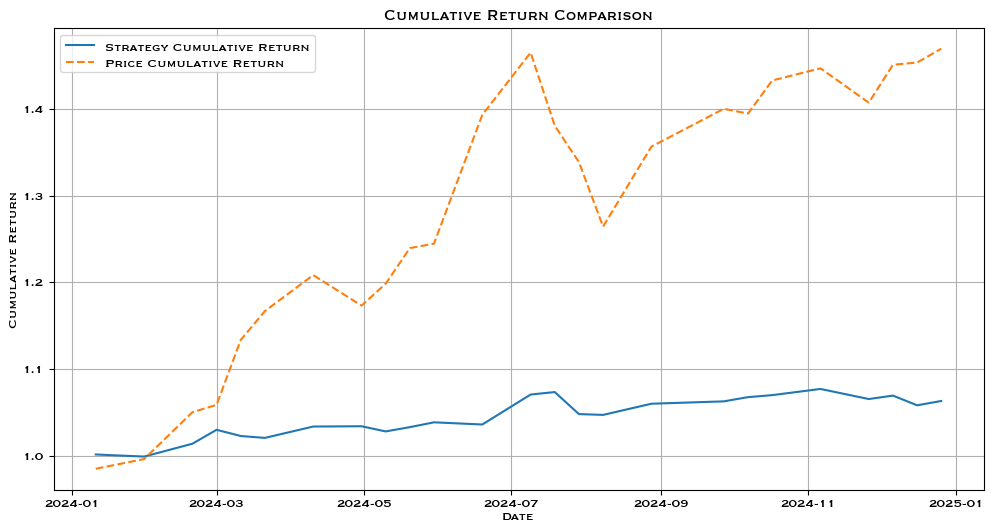

,Trade Date,Strategy Cumulative Return,Price Cumulative Return
0,2024-01-11,1.001242,0.984804
1,2024-01-31,0.998822,0.995923
2,2024-02-20,1.013661,1.050037
3,2024-03-01,1.029730,1.058562
4,2024-03-11,1.022563,1.133432
5,2024-03-21,1.020392,1.166790
6,2024-04-10,1.033493,1.208302
7,2024-04-30,1.033822,1.173091
8,2024-05-10,1.027855,1.198295
9,2024-05-20,1.032791,1.239437


In [ ]:
compare_cumulative_returns(result, basic_results)

### 四因子模型回測

In [16]:
def alpha_backtest_with_internal_mom(
    data: pd.DataFrame,
    factor_df: pd.DataFrame,
    window_size: int = 60,
    holding_days: int = 15,
    top_n: int = 10,
    train_start_year: int = 2020,
    test_start_date: str = "2024-01-01"
) -> pd.DataFrame:
    df = data.merge(factor_df, on="交易日期", how="inner").copy()
    df['交易日期'] = pd.to_datetime(df['交易日期'])
    df = df.sort_values(by=["證券代號", "交易日期"])

    # 🔧 自動計算 MOM（P[t-2m] / P[t-12m] - 1）
    df = df.sort_values(by=["證券代號", "交易日期"])
    df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')
    df['price_lag_2m'] = df.groupby('證券代號')['收盤價'].shift(42)
    df['price_lag_12m'] = df.groupby('證券代號')['收盤價'].shift(252)
    df['MOM'] = df['price_lag_2m'] / df['price_lag_12m'] - 1

    # 分出訓練與測試資料
    train_df = df[df['交易日期'].dt.year < int(test_start_date[:4])].copy()
    test_df_all = df[df['交易日期'] >= test_start_date].copy()

    rebalance_dates = pd.date_range(start=test_start_date, end=test_df_all['交易日期'].max(), freq=f"{holding_days}D")
    results = []

    for i in range(len(rebalance_dates) - 1):
        d0 = rebalance_dates[i]
        d1 = rebalance_dates[i + 1]

        test_df = test_df_all[(test_df_all['交易日期'] > d0) & (test_df_all['交易日期'] <= d1)].copy()
        alpha_list = []

        for stock_id, stock_data in train_df.groupby('證券代號'):
            if stock_data.shape[0] < window_size:
                continue

            factor_cols = ['R_M_minus_R_f', 'SMB', 'HML']
            if 'MOM' in stock_data.columns and stock_data['MOM'].notna().sum() > 0:
                factor_cols.append('MOM')

            try:
                X = sm.add_constant(stock_data[factor_cols])
                y = stock_data['R_i'] - stock_data['R_f']
                model = sm.OLS(y, X).fit()
                alpha = model.params['const']
                alpha_list.append((stock_id, alpha))
            except Exception as e:
                # print(f"[{d0.date()}] 回歸錯誤: {stock_id}, error: {e}")
                continue

        # print(f"[{d0.date()} ~ {d1.date()}] 成功訓練股票數 = {len(alpha_list)}")

        if not alpha_list:
            continue

        alpha_df = pd.DataFrame(alpha_list, columns=['證券代號', 'alpha'])
        top_stocks = alpha_df.sort_values('alpha', ascending=False).head(top_n)['證券代號'].tolist()

        selected = test_df[test_df['證券代號'].isin(top_stocks)]
        if selected.empty:
            print(f"[{d0.date()}] 持股期間無報酬資料")
            continue

        avg_return = selected.groupby('交易日期')['R_i'].mean().mean()
        results.append({'日期': d1, '策略報酬': avg_return})

    result_df = pd.DataFrame(results)
    if not result_df.empty and '策略報酬' in result_df.columns:
        result_df['累積報酬'] = (1 + result_df['策略報酬'].fillna(0)).cumprod()
    else:
        print("⚠️ 最終結果為空，請檢查資料是否齊全或參數是否過窄。")
        result_df['累積報酬'] = np.nan

    return result_df


In [17]:
result = alpha_backtest_with_internal_mom(
    data=model_df,
    factor_df=factor_df,
    window_size=30,
    holding_days=10,
    top_n=15,
    train_start_year=2020,
    test_start_date="2024-01-01"
)

In [18]:
calculate_win_rate(result)

0.6388888888888888

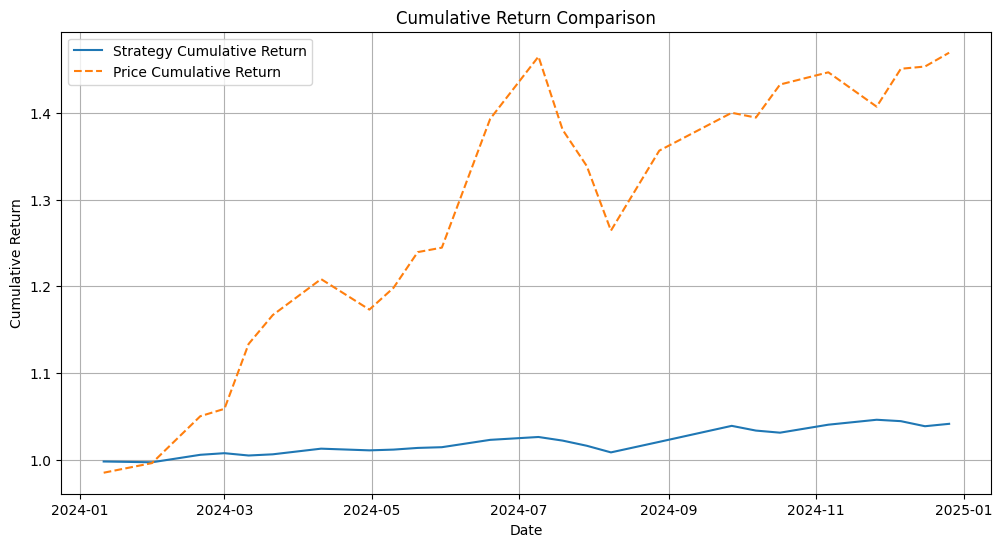

,Trade Date,Strategy Cumulative Return,Price Cumulative Return
0,2024-01-11,0.997758,0.984804
1,2024-01-31,0.996851,0.995923
2,2024-02-20,1.005492,1.050037
3,2024-03-01,1.007351,1.058562
4,2024-03-11,1.004680,1.133432
5,2024-03-21,1.006051,1.166790
6,2024-04-10,1.012572,1.208302
7,2024-04-30,1.010622,1.173091
8,2024-05-10,1.011491,1.198295
9,2024-05-20,1.013429,1.239437


In [21]:
compare_cumulative_returns(result, basic_results)